<a href="https://colab.research.google.com/github/RayenBoukhchina/FakeReviewGuard/blob/main/D%C3%A9tection_automatique_de_fausses_critiques_de_produits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6b070a20b1998ec0065e74bfc85d972d8c27ba3db689c6d9f0b3a0e46235d573
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import lime
from lime.lime_text import LimeTextExplainer
import shap
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## 1. Prétraitement des données

In [10]:
df = pd.read_csv('/content/fake reviews dataset.csv')
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


In [13]:
print("\nInformations sur le dataset:")
print(df.info())

print("\nStatistiques descriptives:")
print(df.describe())


Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None

Statistiques descriptives:
             rating
count  40432.000000
mean       4.256579
std        1.144354
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000


In [14]:
df.rename(columns={'text_': 'text'}, inplace=True)

In [18]:
### Nettoyage du texte ###
def clean_text(text):
    """
    Fonction pour nettoyer le texte:
    1. Conversion en minuscules
    2. Suppression de la ponctuation
    3. Suppression des stopwords
    4. Lemmatisation
    """
    # Vérifier si le texte est une chaîne de caractères
    if not isinstance(text, str):
        return ""

    # Conversion en minuscules
    text = text.lower()

    # Suppression de la ponctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Tokenisation
    tokens = word_tokenize(text)

    # Suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Reconstitution du texte
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Application de la fonction de nettoyage
df['cleaned_text'] = df['text'].apply(clean_text)

In [19]:
print("\nExemple de nettoyage de texte:")
sample_idx = 0
print(f"Original: {df['text'].iloc[sample_idx]}")
print(f"Nettoyé: {df['cleaned_text'].iloc[sample_idx]}")


Exemple de nettoyage de texte:
Original: Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty
Nettoyé: love well made sturdy comfortable love pretty


In [20]:
# Encodage des labels (fake = 0, real = 1)
df['label_encoded'] = df['label'].apply(lambda x: 1 if x == 'OR' else 0)

# Vérification de l'encodage
print("\nDistribution des labels encodés:")
print(df['label_encoded'].value_counts())


Distribution des labels encodés:
label_encoded
0    20216
1    20216
Name: count, dtype: int64


In [23]:
df

,category,rating,label,text,cleaned_text,label_encoded,text_length,cleaned_text_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love well made sturdy comfortable love pretty,0,75,45
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love great upgrade original mine couple year,0,80,44
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,pillow saved back love look feel pillow,0,67,39
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information use great product price,0,81,43
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,nice set good quality set two month,0,85,35
...,...,...,...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...,read review saying bra ran small ordered two b...,1,1694,953
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...,sure exactly would little large small size thi...,0,1304,705
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ...",wear hood wear hood wear jacket without hood 3...,1,1987,1280
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...,liked nothing dress reason gave 4 star ordered...,0,1301,676


In [22]:
### Analyse statistique initiale ###

df['text_length'] = df['text'].apply(len)
df['cleaned_text_length'] = df['cleaned_text'].apply(len)

print("\nStatistiques sur la longueur des textes originaux:")
print(df['text_length'].describe())

print("\nStatistiques sur la longueur des textes nettoyés:")
print(df['cleaned_text_length'].describe())


Statistiques sur la longueur des textes originaux:
count    40432.000000
mean       351.271963
std        369.813570
min         24.000000
25%        107.000000
50%        198.000000
75%        439.000000
max       2827.000000
Name: text_length, dtype: float64

Statistiques sur la longueur des textes nettoyés:
count    40432.000000
mean       200.861817
std        218.653702
min          0.000000
25%         61.000000
50%        112.000000
75%        246.000000
max       2077.000000
Name: cleaned_text_length, dtype: float64


In [24]:
# Distribution des classes
print("\nDistribution des classes:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True) * 100)


Distribution des classes:
label
CG    20216
OR    20216
Name: count, dtype: int64
label
CG    50.0
OR    50.0
Name: proportion, dtype: float64


In [25]:
# Détection et suppression des doublons
duplicate_count = df.duplicated(subset=['text']).sum()
print(f"\nNombre de doublons trouvés: {duplicate_count}")

if duplicate_count > 0:
    df = df.drop_duplicates(subset=['text'])
    print(f"Doublons supprimés. Nouvelle taille du dataset: {len(df)}")


Nombre de doublons trouvés: 20
Doublons supprimés. Nouvelle taille du dataset: 40412


## 2. Analyse exploratoire (EDA)


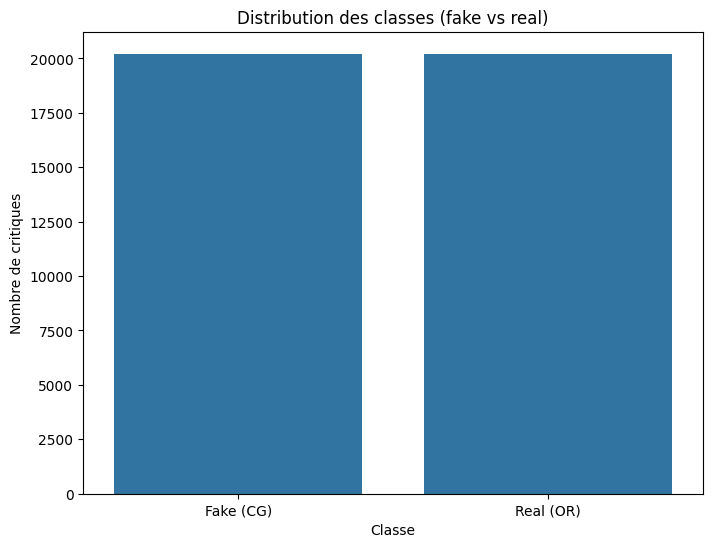

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution des classes (fake vs real)')
plt.xlabel('Classe')
plt.ylabel('Nombre de critiques')
plt.xticks([0, 1], ['Fake (CG)', 'Real (OR)'])
plt.show()

In [27]:
class_percentages = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage de chaque classe:")
for label, percentage in class_percentages.items():
    print(f"{label}: {percentage:.2f}%")


Pourcentage de chaque classe:
OR: 50.02%
CG: 49.98%


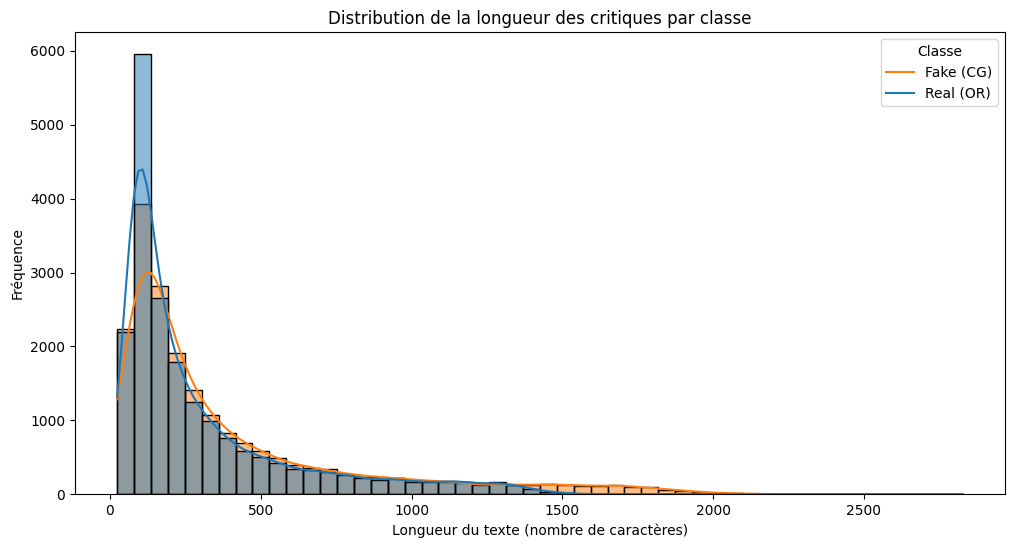

In [28]:
### Longueur des critiques par classe ###

# Visualisation de la longueur des critiques par classe
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution de la longueur des critiques par classe')
plt.xlabel('Longueur du texte (nombre de caractères)')
plt.ylabel('Fréquence')
plt.legend(title='Classe', labels=['Fake (CG)', 'Real (OR)'])
plt.show()

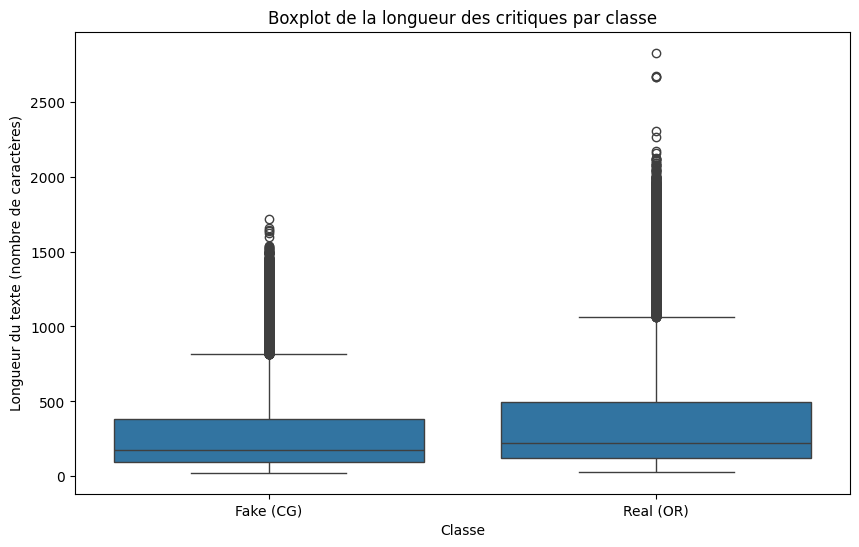

In [29]:
# Boxplot de la longueur des critiques par classe
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Boxplot de la longueur des critiques par classe')
plt.xlabel('Classe')
plt.ylabel('Longueur du texte (nombre de caractères)')
plt.xticks([0, 1], ['Fake (CG)', 'Real (OR)'])
plt.show()

In [30]:
print("\nStatistiques de longueur des textes par classe:")
print(df.groupby('label')['text_length'].describe())


Statistiques de longueur des textes par classe:
         count        mean         std   min    25%    50%    75%     max
label                                                                    
CG     20197.0  305.716691  307.126264  24.0   96.0  174.0  383.0  1717.0
OR     20215.0  396.973337  418.438191  28.0  121.0  224.0  498.0  2827.0


In [31]:
### Visualisation des mots les plus fréquents (WordCloud par classe) ###

# Fonction pour créer un wordcloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

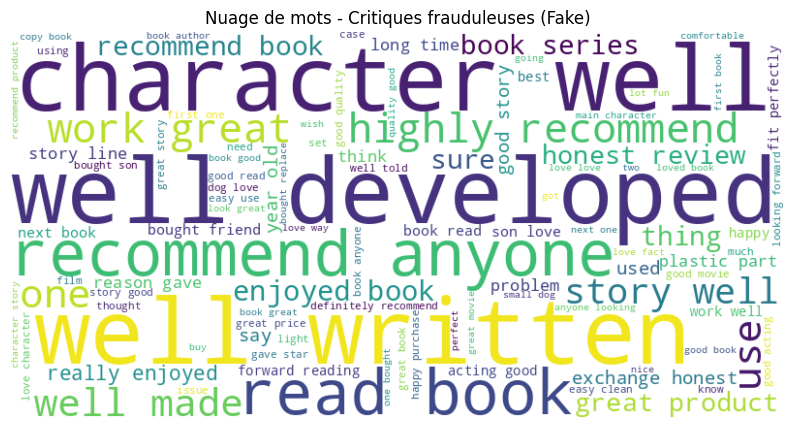

In [32]:
# Wordcloud pour les critiques fake
fake_text = ' '.join(df[df['label'] == 'CG']['cleaned_text'])
create_wordcloud(fake_text, 'Nuage de mots - Critiques frauduleuses (Fake)')

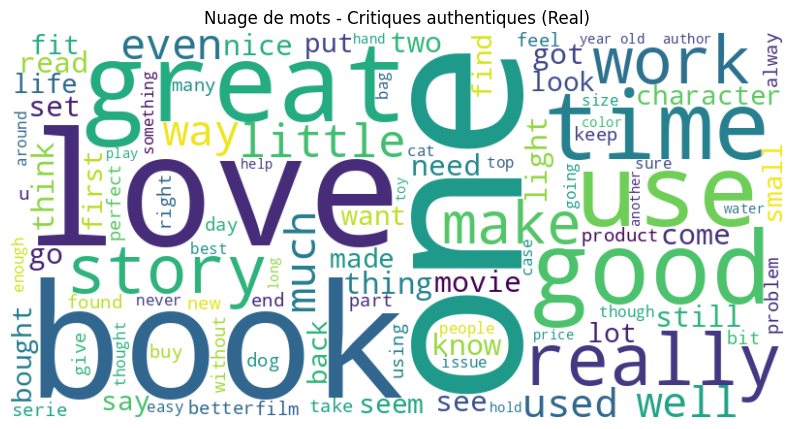

In [33]:
# Wordcloud pour les critiques authentiques
real_text = ' '.join(df[df['label'] == 'OR']['cleaned_text'])
create_wordcloud(real_text, 'Nuage de mots - Critiques authentiques (Real)')

In [34]:
### Autre visualisation pertinente (bigrammes fréquents) ###

# Fonction pour obtenir les bigrammes les plus fréquents
def get_top_ngram(corpus, n=2, k=10):
    from nltk import ngrams
    from collections import Counter

    # Créer une liste pour stocker tous les bigrammes
    all_ngrams = []

    # Parcourir chaque texte dans le corpus
    for text in corpus:
        # Tokeniser le texte
        tokens = word_tokenize(text)
        # Générer les bigrammes
        text_ngrams = list(ngrams(tokens, n))
        # Ajouter à la liste générale
        all_ngrams.extend(text_ngrams)

    # Compter les bigrammes et retourner les k plus fréquents
    ngram_freq = Counter(all_ngrams).most_common(k)
    return ngram_freq

In [35]:
# Obtenir les bigrammes les plus fréquents par classe
fake_bigrams = get_top_ngram(df[df['label'] == 'CG']['cleaned_text'], n=2, k=15)
real_bigrams = get_top_ngram(df[df['label'] == 'OR']['cleaned_text'], n=2, k=15)

In [36]:
# Préparer les données pour la visualisation
fake_bi_words = [' '.join(bi[0]) for bi in fake_bigrams]
fake_bi_counts = [bi[1] for bi in fake_bigrams]
real_bi_words = [' '.join(bi[0]) for bi in real_bigrams]
real_bi_counts = [bi[1] for bi in real_bigrams]

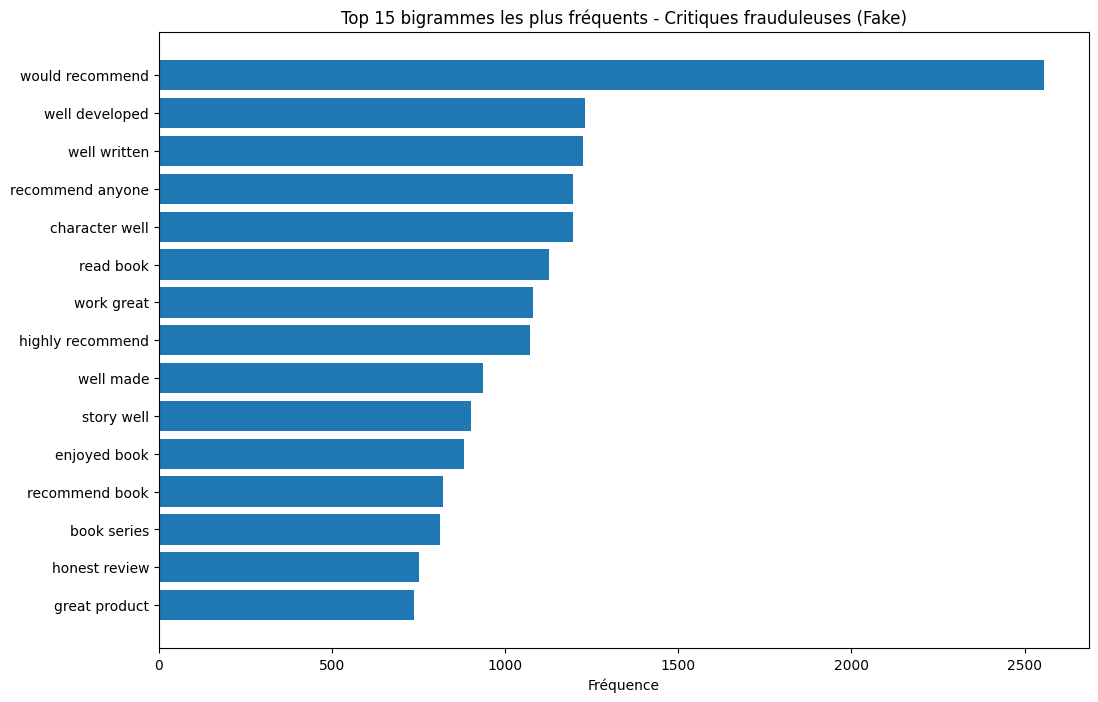

In [37]:
# Visualisation des bigrammes les plus fréquents pour les critiques fake
plt.figure(figsize=(12, 8))
plt.barh(fake_bi_words[::-1], fake_bi_counts[::-1])
plt.title('Top 15 bigrammes les plus fréquents - Critiques frauduleuses (Fake)')
plt.xlabel('Fréquence')
plt.show()

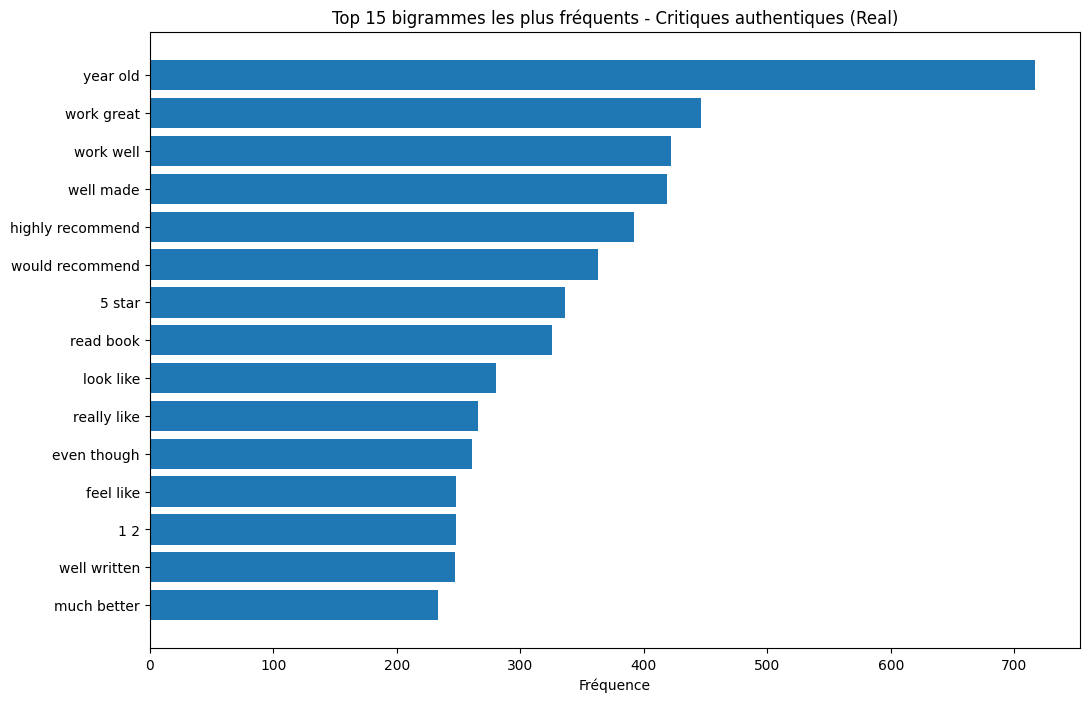

In [38]:
# Visualisation des bigrammes les plus fréquents pour les critiques authentiques
plt.figure(figsize=(12, 8))
plt.barh(real_bi_words[::-1], real_bi_counts[::-1])
plt.title('Top 15 bigrammes les plus fréquents - Critiques authentiques (Real)')
plt.xlabel('Fréquence')
plt.show()


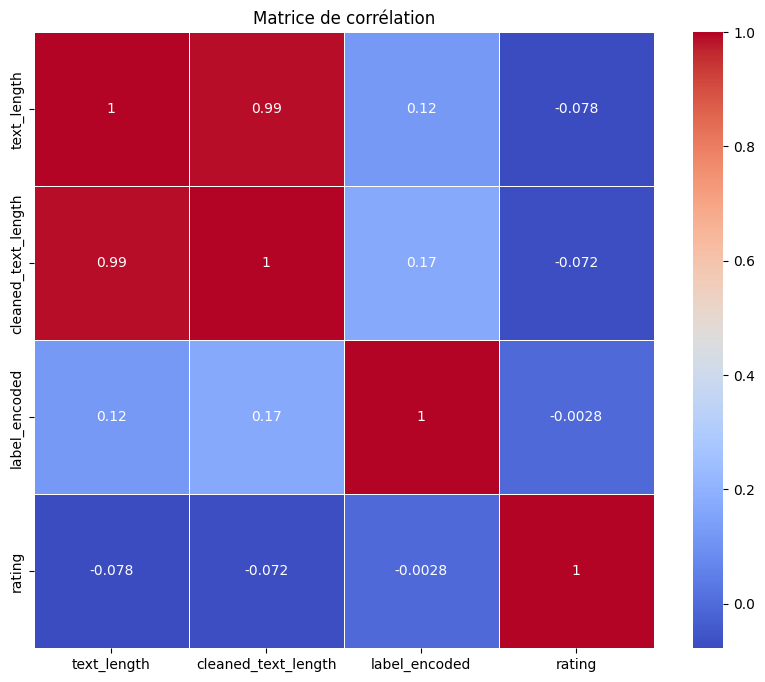

In [39]:
# Heatmap de corrélation entre les variables numériques
numeric_cols = ['text_length', 'cleaned_text_length', 'label_encoded']
if 'rating' in df.columns:
    numeric_cols.append('rating')

plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()

## 3. Vectorisation du texte


In [40]:
# Vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [41]:
# Affichage des dimensions et informations sur la vectorisation
print("\nInformations sur la vectorisation TF-IDF:")
print(f"Dimensions de la matrice TF-IDF: {X_tfidf.shape}")
print(f"Taille du vocabulaire: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Type de la matrice: {type(X_tfidf)}")
print(f"Densité de la matrice: {X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]) * 100:.2f}%")
print(f"Mémoire utilisée (estimation): {X_tfidf.data.nbytes / (1024*1024):.2f} Mo")


Informations sur la vectorisation TF-IDF:
Dimensions de la matrice TF-IDF: (40412, 5000)
Taille du vocabulaire: 5000
Type de la matrice: <class 'scipy.sparse._csr.csr_matrix'>
Densité de la matrice: 0.46%
Mémoire utilisée (estimation): 7.07 Mo


In [43]:
# Top 10 des mots les plus importants selon le score TF-IDF moyen
tfidf_means = np.asarray(X_tfidf.mean(axis=0))[0]
top_indices = tfidf_means.argsort()[-10:][::-1]
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nTop 10 des mots avec le score TF-IDF moyen le plus élevé:")
for idx in top_indices:
    print(f"{feature_names[idx]}: {tfidf_means[idx]:.4f}")


Top 10 des mots avec le score TF-IDF moyen le plus élevé:
book: 0.0372
great: 0.0350
love: 0.0346
good: 0.0290
one: 0.0281
story: 0.0232
well: 0.0229
read: 0.0226
like: 0.0198
little: 0.0189


## 4. Modélisation et évaluation des performances

In [44]:
# Préparation des données pour la modélisation
X = X_tfidf
y = df['label_encoded']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [45]:
print(f"Taille de l'ensemble d'entraînement: {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} échantillons")

Taille de l'ensemble d'entraînement: 28288 échantillons
Taille de l'ensemble de test: 12124 échantillons


In [48]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Métriques d'évaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Affichage des résultats
    print(f"\nRésultats pour {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.xticks([0.5, 1.5], ['Fake', 'Real'])
    plt.yticks([0.5, 1.5], ['Fake', 'Real'])
    plt.show()

    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend()
    plt.show()

    return model, accuracy, precision, recall, f1, auc, y_pred, y_prob


Résultats pour Régression Logistique:
Accuracy: 0.8689
Precision: 0.8674
Recall: 0.8712
F1-score: 0.8693
AUC: 0.9436


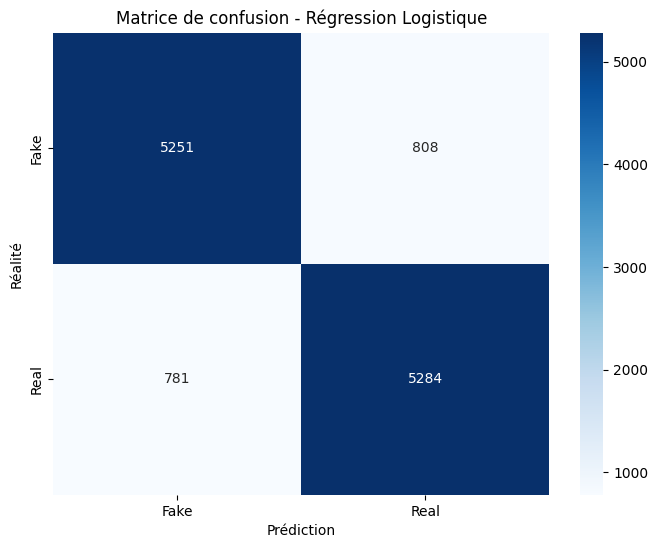

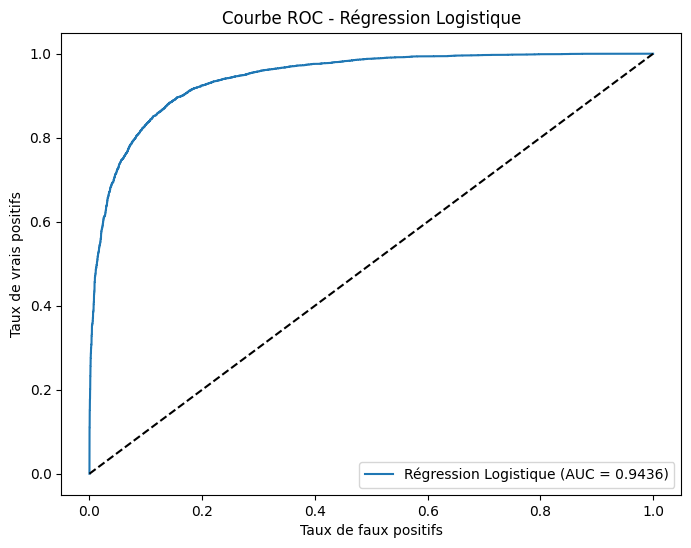

In [49]:
# Régression logistique (baseline)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_results = evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Régression Logistique")


Résultats pour Réseau de Neurones (MLP):
Accuracy: 0.8609
Precision: 0.8669
Recall: 0.8528
F1-score: 0.8598
AUC: 0.9384


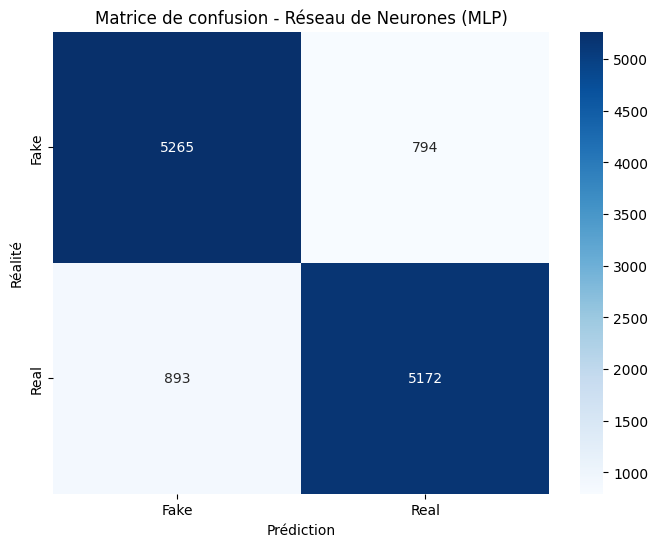

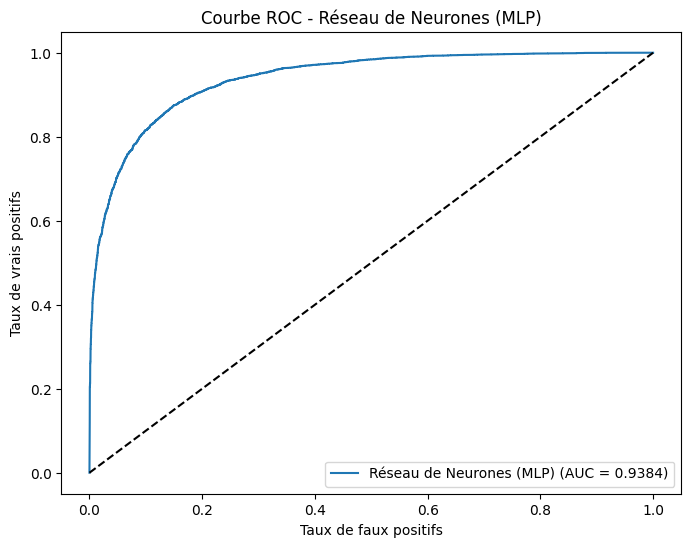

In [50]:
# Réseau de neurones simple (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_results = evaluate_model(mlp_model, X_train, X_test, y_train, y_test, "Réseau de Neurones (MLP)")

In [51]:
# Comparaison des modèles
models = ["Régression Logistique", "Réseau de Neurones (MLP)"]
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "AUC"]

results_data = {
    "Régression Logistique": lr_results[1:6],
    "Réseau de Neurones (MLP)": mlp_results[1:6]
}

results_df = pd.DataFrame(results_data, index=metrics)
print("\nComparaison des performances des modèles:")
print(results_df)



Comparaison des performances des modèles:
           Régression Logistique  Réseau de Neurones (MLP)
Accuracy                0.868938                  0.860855
Precision               0.867367                  0.866913
Recall                  0.871228                  0.852762
F1-score                0.869293                  0.859779
AUC                     0.943593                  0.938406


<Figure size 1200x800 with 0 Axes>

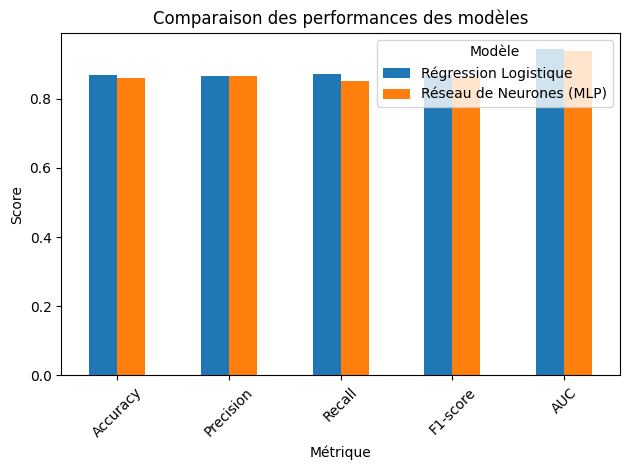

In [52]:
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar')
plt.title('Comparaison des performances des modèles')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()

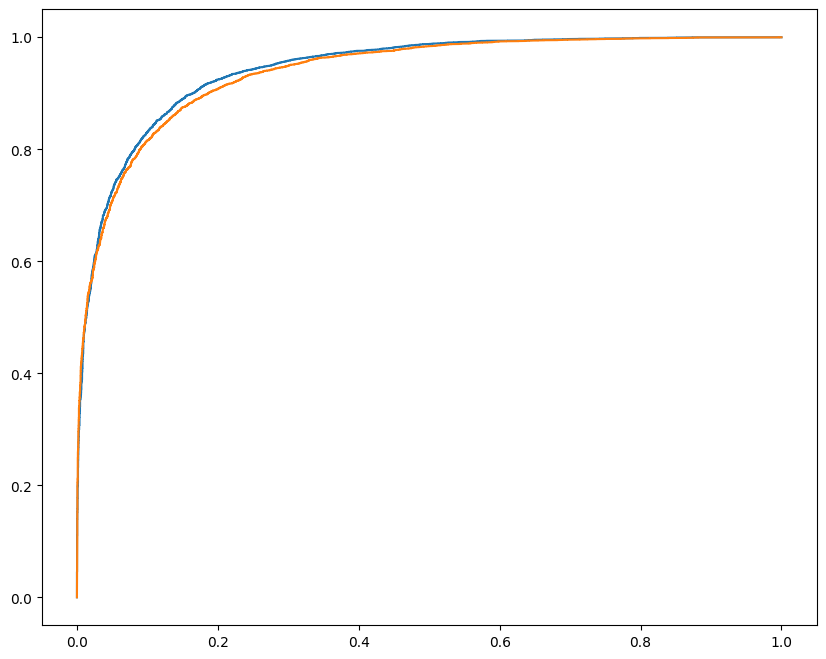

In [54]:
plt.figure(figsize=(10, 8))
# ROC pour la régression logistique
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_results[7])
plt.plot(fpr_lr, tpr_lr, label=f'Régression Logistique (AUC = {lr_results[5]:.4f})')

# ROC pour le réseau de neurones
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_results[7])
plt.plot(fpr_mlp, tpr_mlp, label=f'Réseau de Neurones (AUC = {mlp_results[5]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Comparaison des courbes ROC')
plt.legend()
plt.grid(True)
plt.show()

## 5. Interprétation des résultats avec LIME et SHAP

In [55]:
# Sélection du meilleur modèle pour l'interprétation
# Supposons que la régression logistique a donné les meilleurs résultats
best_model = lr_model if lr_results[5] > mlp_results[5] else mlp_model
best_model_name = "Régression Logistique" if lr_results[5] > mlp_results[5] else "Réseau de Neurones (MLP)"

In [56]:
# Création de l'explainer LIME
class_names = ['Fake', 'Real']
explainer = LimeTextExplainer(class_names=class_names)

In [57]:
# Fonction pour prédire les probabilités (utilisée par LIME)
def predictor(texts):
    # Vectorisation des textes
    vectorized_texts = tfidf_vectorizer.transform(texts)
    # Prédiction des probabilités
    return best_model.predict_proba(vectorized_texts)

In [59]:
# Choisir 2 exemples : un fake et un real correctement classifiés

# Get the indices of the test set from the original DataFrame
test_indices = y_test.index

# Filter the original DataFrame to include only the test set rows
df_test = df.loc[test_indices]

# Now, find the index of a true fake example within the test set rows
# We are looking for a row in the test set (df_test) where the true label (label_encoded) is 0
# We also need to ensure this is within the test set, which df_test already guarantees.
# The condition (y_test.values == 0) is equivalent to df_test['label_encoded'] == 0
# when considering the corresponding rows in df_test and y_test.
# However, to make it clear and avoid potential index alignment issues,
# it's safer to use the label_encoded column of the filtered test set DataFrame.
true_fake_indices_in_test_set = df_test[(df_test['label_encoded'] == 0)].index

# Select the first index from this filtered list
if not true_fake_indices_in_test_set.empty:
    true_fake_idx = true_fake_indices_in_test_set[0]
else:
    # Handle the case where no such example exists in the test set (should be rare given the data)
    print("Warning: No true fake examples found in the test set.")
    true_fake_idx = None # Or handle appropriately

# Find the index of a true real example within the test set rows
true_real_indices_in_test_set = df_test[(df_test['label_encoded'] == 1)].index

# Select the first index from this filtered list
if not true_real_indices_in_test_set.empty:
    true_real_idx = true_real_indices_in_test_set[0]
else:
     # Handle the case where no such example exists in the test set (should be rare given the data)
    print("Warning: No true real examples found in the test set.")
    true_real_idx = None # Or handle appropriately

print(f"Index of a true fake example in the original df: {true_fake_idx}")
print(f"Index of a true real example in the original df: {true_real_idx}")

Index of a true fake example in the original df: 21040
Index of a true real example in the original df: 10246


In [62]:
# Explication pour l'exemple fake
fake_text = df.loc[true_fake_idx, 'cleaned_text']
vectorized_fake_text = tfidf_vectorizer.transform([fake_text])
fake_exp = explainer.explain_instance(fake_text, predictor, num_features=10)

In [67]:
print(f"\nExplication LIME pour une critique frauduleuse (Fake):")
print(f"Texte original: {df.loc[true_fake_idx, 'text'][:200]}...")
print(f"Prédiction du modèle: {best_model.predict_proba(vectorized_fake_text)[0][1]:.4f} (probabilité d'être authentique)")
print("\nMots influents:")
for word, score in fake_exp.as_list():
    print(f"{word}: {score:.4f}")


Explication LIME pour une critique frauduleuse (Fake):
Texte original: Works well but doggie slides around on the leash and gets caught in her harness. She does not like the leash but the leash is a bit too loose...
Prédiction du modèle: 0.6695 (probabilité d'être authentique)

Mots influents:
bit: -0.1565
leash: 0.1163
harness: -0.0810
around: 0.0528
like: 0.0523
caught: 0.0442
slide: 0.0259
get: -0.0220
work: 0.0142
well: 0.0116


<Figure size 1200x600 with 0 Axes>

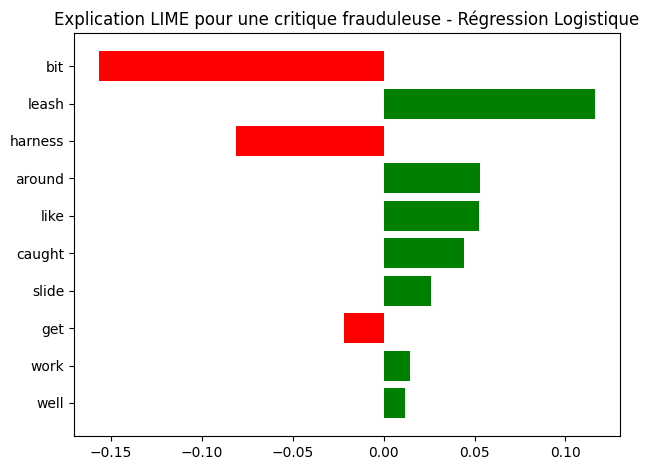

In [68]:
plt.figure(figsize=(12, 6))
fake_exp.as_pyplot_figure()
plt.title(f"Explication LIME pour une critique frauduleuse - {best_model_name}")
plt.tight_layout()
plt.show()

In [70]:
# Explication pour l'exemple real
real_text = df.loc[true_real_idx, 'cleaned_text']
vectorized_real_text = tfidf_vectorizer.transform([real_text])
real_exp = explainer.explain_instance(real_text, predictor, num_features=10)

print(f"\nExplication LIME pour une critique authentique (Real):")
print(f"Texte original: {df.loc[true_real_idx, 'text'][:200]}...")
print(f"Prédiction du modèle: {best_model.predict_proba(vectorized_real_text)[0][1]:.4f} (probabilité d'être authentique)")
print("\nMots influents:")
for word, score in real_exp.as_list():
    print(f"{word}: {score:.4f}")



Explication LIME pour une critique authentique (Real):
Texte original: This card is very fast. With other cards, including others from SanDisk, when shooting stills with my Olympus E-M1 I'd have to wait for the image to save. With this card saving is instant. Highly reco...
Prédiction du modèle: 0.9824 (probabilité d'être authentique)

Mots influents:
lock: 0.0265
others: 0.0221
recommended: 0.0179
fast: 0.0153
may: 0.0134
shooting: 0.0130
slow: -0.0124
card: -0.0119
writes: 0.0111
image: -0.0057


<Figure size 1200x600 with 0 Axes>

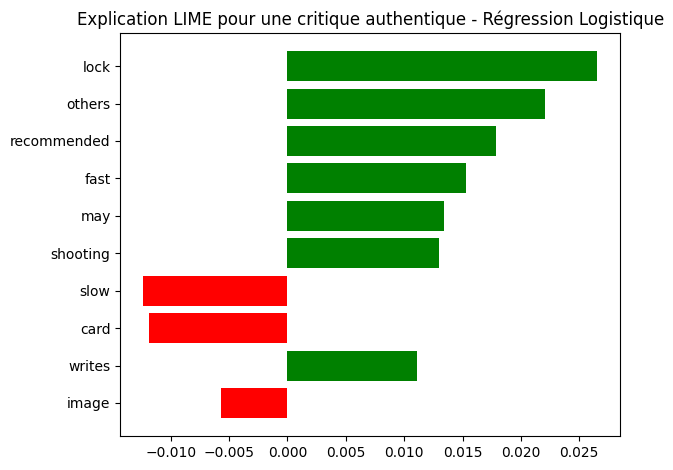

In [71]:
plt.figure(figsize=(12, 6))
real_exp.as_pyplot_figure()
plt.title(f"Explication LIME pour une critique authentique - {best_model_name}")
plt.tight_layout()
plt.show()

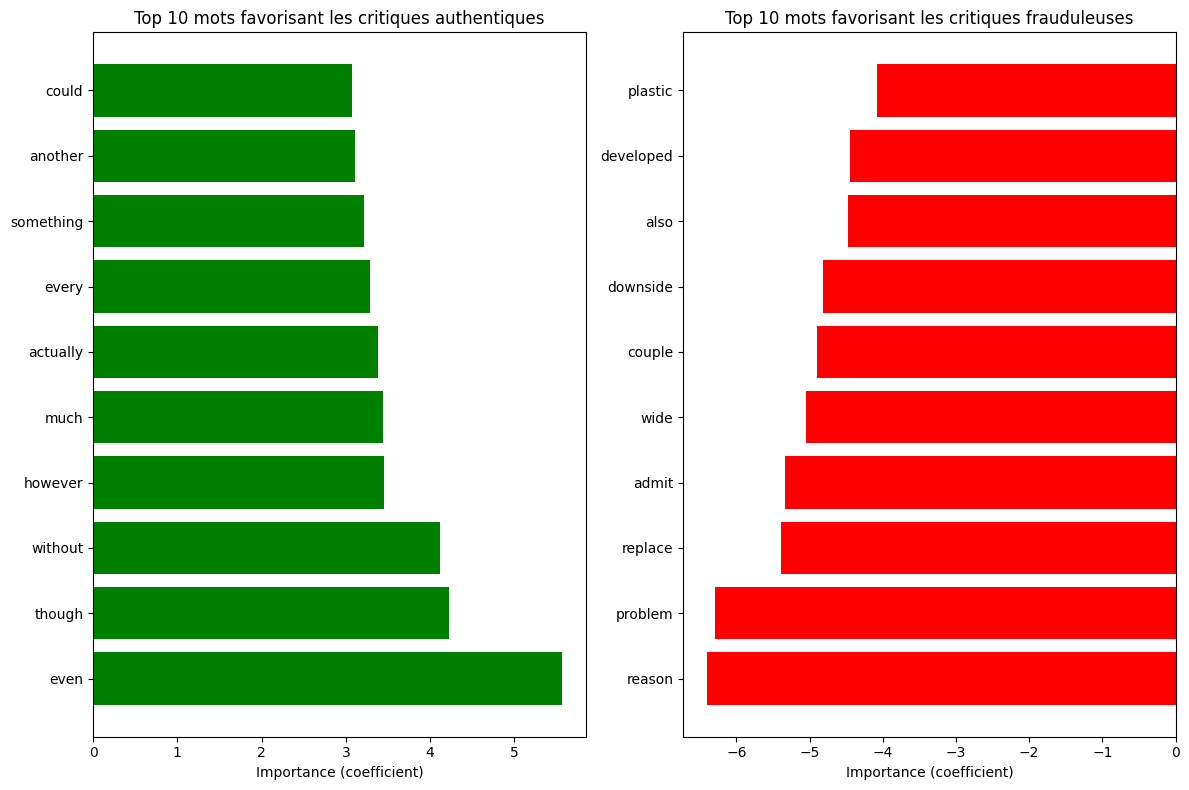

In [74]:
# Utilisation de SHAP pour l'interprétation globale du modèle
if best_model_name == "Régression Logistique":
    # Pour la régression logistique, nous pouvons utiliser les coefficients
    feature_importance = pd.DataFrame({
        'feature': tfidf_vectorizer.get_feature_names_out(),
        'importance': best_model.coef_[0]
    })
    # Sélection des 20 mots les plus importants (positifs et négatifs)
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    top_positive = feature_importance.head(10)
    top_negative = feature_importance.tail(10).iloc[::-1]  # Inverser l'ordre pour l'affichage

    # Visualisation des mots les plus importants
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.barh(top_positive['feature'], top_positive['importance'], color='green')
    plt.title('Top 10 mots favorisant les critiques authentiques')
    plt.xlabel('Importance (coefficient)')

    plt.subplot(1, 2, 2)
    plt.barh(top_negative['feature'], top_negative['importance'], color='red')
    plt.title('Top 10 mots favorisant les critiques frauduleuses')
    plt.xlabel('Importance (coefficient)')

    plt.tight_layout()
    plt.show()

## 6. Réponses aux questions théoriques

#### 1. Pourquoi le nettoyage du texte est-il crucial avant vectorisation ?
Le nettoyage du texte est crucial avant la vectorisation pour plusieurs raisons :

1. **Réduction du bruit et standardisation** : En supprimant la ponctuation, en convertissant en minuscules et en éliminant les caractères spéciaux, nous réduisons le bruit dans les données et standardisons le format du texte, ce qui permet de traiter les mêmes mots écrits différemment de manière uniforme.

2. **Réduction de la dimensionnalité** : En supprimant les stopwords (mots très fréquents comme "le", "la", "et") qui n'apportent pas d'information discriminante, nous réduisons la taille du vocabulaire et donc la dimensionnalité de l'espace vectoriel, ce qui améliore l'efficacité des algorithmes d'apprentissage.

3. **Normalisation lexicale** : La lemmatisation ou le stemming permettent de regrouper les différentes formes d'un même mot ("marcher", "marchant", "marché") sous une forme canonique, ce qui aide à capturer la sémantique et non juste la forme superficielle des mots.

4. **Amélioration de la qualité de la vectorisation** : Un texte nettoyé permet d'obtenir des vecteurs plus pertinents et moins dispersés, ce qui améliore la capacité du modèle à généraliser et à identifier des motifs significatifs dans les données.

5. **Réduction des problèmes de mémoire et de calcul** : En réduisant le vocabulaire, nous diminuons la taille des matrices créées lors de la vectorisation, ce qui optimise l'utilisation de la mémoire et accélère les calculs.

Dans notre cas de détection de fausses critiques, le nettoyage permet de se concentrer sur le contenu sémantique réel des critiques plutôt que sur des variations stylistiques superficielles qui pourraient ne pas être discriminantes entre les critiques authentiques et frauduleuses.


## 2. Que mesure le F1-score et pourquoi est-il souvent plus pertinent que la simple accuracy ?
Le F1-score est la moyenne harmonique entre la précision et le rappel:

**F1 = 2 * (précision * rappel) / (précision + rappel)**

avec :
Précision = Vrais positifs / (Vrais positifs + Faux positifs)

Rappel = Vrais positifs / (Vrais positifs + Faux négatifs)

Il est souvent plus pertinent que l'accuracy car:

* Il tient compte à la fois des faux positifs et des faux négatifs
* Il est particulièrement utile dans les cas de classes déséquilibrées
* Il donne une vision plus complète des performances du modèle

==> Dans notre détection de fausses critiques, si les classes sont déséquilibrées (plus de critiques authentiques que frauduleuses par exemple), un modèle qui prédirait toujours "authentique" aurait une bonne accuracy mais un F1-score faible, révélant son inefficacité réelle.

## 3. Quelle est la différence entre TF-IDF et les embeddings comme Word2Vec ?
TF-IDF et Word2Vec représentent deux approches différentes de représentation du texte:

**TF-IDF (Term Frequency-Inverse Document Frequency):**

* Représentation statistique basée sur la fréquence des mots
* Ne capture pas le contexte ou la sémantique des mots
* Crée des vecteurs creux (sparse) de grande dimension
* Plus simple à implémenter et moins coûteux en calcul

**Word2Vec :**

* Représentation par plongement de mots (word embeddings) utilisant des réseaux de neurones
* Capture la sémantique et les relations entre les mots (mots similaires proches dans l'espace vectoriel)
* Crée des vecteurs denses de dimension fixe et généralement plus petite
* Nécessite plus de données d'entraînement et de ressources de calcul

==> Dans notre projet, nous avons utilisé TF-IDF car il est suffisant pour la classification de critiques et plus adapté à des datasets de taille moyenne, mais Word2Vec pourrait potentiellement capturer des nuances sémantiques plus fines.

## 4. Comment le déséquilibre des classes peut-il impacter les performances d'un modèle ?
Le déséquilibre des classes peut avoir plusieurs impacts négatifs:

* Le modèle tend à favoriser la classe majoritaire pour maximiser l'accuracy globale
* Les métriques comme l'accuracy deviennent trompeuses (un modèle prédisant toujours la classe majoritaire aurait une bonne accuracy)
* La capacité du modèle à détecter la classe minoritaire est réduite
* Les algorithmes sensibles au déséquilibre (comme certains arbres de décision) peuvent produire des modèles biaisés

==> Pour notre détection de fausses critiques, si les critiques authentiques sont beaucoup plus nombreuses, le modèle pourrait avoir tendance à classifier la plupart des critiques comme authentiques, manquant ainsi l'objectif principal de détecter les critiques frauduleuses.

## 5. Quels sont les enjeux éthiques liés à la détection automatisée de contenus frauduleux ?
La détection automatisée de contenus frauduleux soulève plusieurs enjeux éthiques:

* **Faux positifs:** Des critiques authentiques pourraient être incorrectement classées comme frauduleuses, pénalisant injustement des utilisateurs honnêtes
* **Transparence algorithmique:** Les personnes dont les critiques sont rejetées devraient idéalement comprendre pourquoi
* **Biais potentiels:** Le modèle pourrait développer des biais contre certains styles d'écriture ou expressions culturelles spécifiques
* **Surveillance et vie privée:** L'analyse automatique de contenus pose des questions sur le niveau de surveillance acceptable
* **Contournement du système:** L'existence de tels systèmes peut conduire à une "course à l'armement" où les créateurs de fausses critiques adaptent leurs techniques